# **Model Segmentasi Konjungtiva Palpebral**

# **1. Menginstall dan Memuat Library**

## Menginstall library

In [ ]:
!pip install torch torchvision numpy matplotlib opencv-python scikit-image albumentations scikit-learn tqdm pillow segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Mengimport Library

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import requests

Sel ini mengimpor semua pustaka Python yang diperlukan untuk proyek segmentasi gambar. Ini mencakup torch dan segmentation_models_pytorch untuk membangun dan melatih model deep learning, cv2 dan albumentations untuk memproses dan augmentasi gambar, pandas untuk mengelola data, serta sklearn untuk mengevaluasi performa model.

In [ ]:
# Download Dataset ZIP
print("Downloading dataset...")
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/yxwjgcndg2-1.zip"
response = requests.get(url)

with open("yxwjgcndg2-1.zip", "wb") as f:
    f.write(response.content)

print("Download dataset selesai.")

# Ekstrak dataset
zip_path = "yxwjgcndg2-1.zip"
extract_folder = "extracted_dataset"
os.makedirs(extract_folder, exist_ok=True)

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Dataset berhasil diekstrak ke folder: {extract_folder}")


Download dataset selesai.
Dataset berhasil diekstrak ke folder: extracted_dataset


Sel ini mengunduh berkas ZIP dari URL yang diberikan, lalu mengekstrak isinya ke dalam folder baru bernama extracted_dataset.

# **2. Preprocessing Data Image**


In [ ]:
# Setup paths
DATASET_DIR = "/kaggle/working/extracted_dataset/Eye Conjunctiva Segmentation Dataset"
IMAGE_DIR = os.path.join(DATASET_DIR, "Images")
MASK_DIR_ANNOTATOR1 = os.path.join(DATASET_DIR, "Masks Annotator 1")
MASK_DIR_ANNOTATOR2 = os.path.join(DATASET_DIR, "Masks Annotator 2")

image_paths = [os.path.join(IMAGE_DIR, img) for img in os.listdir(IMAGE_DIR)]
mask_paths_annotator1 = [os.path.join(MASK_DIR_ANNOTATOR1, mask) for mask in os.listdir(MASK_DIR_ANNOTATOR1)]

# Gunakan salah satu annotator untuk label
train_images, valid_images, train_masks, valid_masks = train_test_split(
    image_paths, mask_paths_annotator1, test_size=0.2, random_state=42)

class ConjunctivaDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.float()


Sel ini menentukan lokasi folder data (gambar dan masker). Lalu, ia memisahkan data menjadi set pelatihan dan validasi. Terakhir, kode ini mendefinisikan kelas ConjunctivaDataset untuk memuat gambar dan maskernya, serta menerapkan transformasi yang diperlukan.

## 1. Transformasi dan Augmentasi Data untuk Training

In [ ]:
# Data augmentation transforms
train_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=0.5),
        A.MedianBlur(blur_limit=3, p=0.5),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.PiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),
    ], p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

valid_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_35/3047571927.py:31: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: This augmenter is very slow. Try to use ``ElasticTransform`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


Sel ini mendefinisikan dua set transformasi: train_transform untuk augmentasi data yang ekstensif (misalnya, membalik, memutar, mengubah kecerahan/kontras) untuk meningkatkan variasi data pelatihan, dan valid_transform yang lebih sederhana untuk normalisasi dan pengubahan ukuran data validasi.

## 2. Membuat DataLoader

In [ ]:
# Create datasets
train_dataset = ConjunctivaDataset(train_images, train_masks, transform=train_transform)
valid_dataset = ConjunctivaDataset(valid_images, valid_masks, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# Initialize UNet with ResNet backbone
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Sel ini membuat objek dataset untuk pelatihan dan validasi menggunakan data yang telah dipersiapkan dan transformasi yang ditentukan. Kemudian, DataLoader dibuat untuk memuat data dalam batch dan mengatur shuffling. Terakhir, ia menginisialisasi model U-Net dengan backbone ResNet dan menentukan perangkat (cuda atau cpu) yang akan digunakan untuk komputasi.

# **3. Modeling**

In [ ]:
# Create UNet model with ResNet50 encoder
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation=None,                # activation function, None means no activation
)

model = model.to(device)

# Define loss functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()

    def forward(self, pred, target):
        dice_loss = self.dice_loss(pred, target)
        focal_loss = self.focal_loss(pred, target)
        return self.alpha * dice_loss + self.beta * focal_loss

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Sel ini menginisialisasi model UNet dengan encoder ResNet50 yang sudah dilatih sebelumnya (imagenet). Setelah itu, sel ini mendefinisikan tiga fungsi loss: DiceLoss untuk mengukur kesamaan antara prediksi dan target, FocalLoss untuk menangani ketidakseimbangan kelas, dan CombinedLoss yang merupakan kombinasi dari kedua loss tersebut.

In [ ]:
# Initialize loss and optimizer
criterion = CombinedLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# Metrics calculation
def calculate_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / (union + 1e-8)
    return iou

def calculate_dice(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    dice = (2. * intersection) / (pred.sum() + target.sum() + 1e-8)
    return dice

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = 0

    progress_bar = tqdm(loader, desc="Training")
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        masks = masks.unsqueeze(1)  # Menambahkan dimensi channel -> (B, 1, H, W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # Calculate metrics
        iou = calculate_iou(outputs, masks)
        dice = calculate_dice(outputs, masks)

        total_loss += loss.item()
        total_iou += iou.item()
        total_dice += dice.item()
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'IoU': f'{iou.item():.4f}',
            'Dice': f'{dice.item():.4f}'
        })

    return {
        'loss': total_loss / num_batches,
        'iou': total_iou / num_batches,
        'dice': total_dice / num_batches
    }

Sel ini mengatur fungsi loss (CombinedLoss), menginisialisasi optimizer (AdamW) untuk memperbarui bobot model, dan penjadwal learning rate (CosineAnnealingLR). Ia juga mendefinisikan fungsi metrik calculate_iou dan calculate_dice, serta fungsi train_epoch yang mengelola satu iterasi pelatihan model, menghitung loss dan metrik (IoU, Dice), dan memperbarui bobot model.

In [ ]:
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = 0

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validation")
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            masks = masks.unsqueeze(1)
            loss = criterion(outputs, masks)

            # Calculate metrics
            iou = calculate_iou(outputs, masks)
            dice = calculate_dice(outputs, masks)

            total_loss += loss.item()
            total_iou += iou.item()
            total_dice += dice.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'IoU': f'{iou.item():.4f}',
                'Dice': f'{dice.item():.4f}'
            })

    return {
        'loss': total_loss / num_batches,
        'iou': total_iou / num_batches,
        'dice': total_dice / num_batches,
    }


Sel ini mendefinisikan fungsi validate_epoch, yang digunakan untuk mengevaluasi kinerja model pada set validasi. Fungsi ini menghitung loss dan metrik seperti IoU dan Dice, tanpa melakukan backpropagation atau pembaruan bobot model.

In [ ]:

# Training loop
num_epochs = 20
best_iou = 0.0
train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []


print("Starting UNet+ResNet50 training...")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print("-" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # Training
    train_metrics = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_metrics = validate_epoch(model, valid_loader, criterion, device)

    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Store metrics
    train_losses.append(train_metrics['loss'])
    val_losses.append(val_metrics['loss'])
    train_ious.append(train_metrics['iou'])
    val_ious.append(val_metrics['iou'])
    train_dices.append(train_metrics['dice'])
    val_dices.append(val_metrics['dice'])

    print(f"Train - Loss: {train_metrics['loss']:.4f}, IoU: {train_metrics['iou']:.4f}, Dice: {train_metrics['dice']:.4f}")
    print(f"Val   - Loss: {val_metrics['loss']:.4f}, IoU: {val_metrics['iou']:.4f}, Dice: {val_metrics['dice']:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")

    # Save best model
    if val_metrics['iou'] > best_iou:
        best_iou = val_metrics['iou']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_iou': best_iou,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics
        }, "best_unet_resnet50_model.pth")
        print(f"✓ New best model saved with IoU: {best_iou:.4f}")

    print("-" * 60)

print("Training selesai!")

Starting UNet+ResNet50 training...
Training samples: 437
Validation samples: 110
------------------------------------------------------------

Epoch [1/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it, Loss=0.5151, IoU=0.2739, Dice=0.4300]


Train - Loss: 0.5406, IoU: 0.0899, Dice: 0.1579
Val   - Loss: 0.5165, IoU: 0.2518, Dice: 0.4003
Learning Rate: 9.94e-05
✓ New best model saved with IoU: 0.2518
------------------------------------------------------------

Epoch [2/20]


Validation: 100%|██████████| 14/14 [00:26<00:00,  1.90s/it, Loss=0.4939, IoU=0.5961, Dice=0.7469]


Train - Loss: 0.5028, IoU: 0.3318, Dice: 0.4926
Val   - Loss: 0.4944, IoU: 0.5562, Dice: 0.7120
Learning Rate: 9.76e-05
✓ New best model saved with IoU: 0.5562
------------------------------------------------------------

Epoch [3/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.93s/it, Loss=0.4836, IoU=0.5826, Dice=0.7363]


Train - Loss: 0.4890, IoU: 0.4507, Dice: 0.6184
Val   - Loss: 0.4833, IoU: 0.5843, Dice: 0.7348
Learning Rate: 9.46e-05
✓ New best model saved with IoU: 0.5843
------------------------------------------------------------

Epoch [4/20]


Validation: 100%|██████████| 14/14 [00:26<00:00,  1.91s/it, Loss=0.4757, IoU=0.6740, Dice=0.8053]


Train - Loss: 0.4805, IoU: 0.5084, Dice: 0.6723
Val   - Loss: 0.4759, IoU: 0.6181, Dice: 0.7618
Learning Rate: 9.05e-05
✓ New best model saved with IoU: 0.6181
------------------------------------------------------------

Epoch [5/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.95s/it, Loss=0.4670, IoU=0.6378, Dice=0.7789]


Train - Loss: 0.4734, IoU: 0.5280, Dice: 0.6880
Val   - Loss: 0.4680, IoU: 0.6103, Dice: 0.7565
Learning Rate: 8.55e-05
------------------------------------------------------------

Epoch [6/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.93s/it, Loss=0.4603, IoU=0.6546, Dice=0.7912]


Train - Loss: 0.4670, IoU: 0.5444, Dice: 0.7033
Val   - Loss: 0.4621, IoU: 0.6237, Dice: 0.7660
Learning Rate: 7.96e-05
✓ New best model saved with IoU: 0.6237
------------------------------------------------------------

Epoch [7/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it, Loss=0.4520, IoU=0.7086, Dice=0.8295]


Train - Loss: 0.4595, IoU: 0.5465, Dice: 0.7037
Val   - Loss: 0.4531, IoU: 0.6967, Dice: 0.8197
Learning Rate: 7.30e-05
✓ New best model saved with IoU: 0.6967
------------------------------------------------------------

Epoch [8/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.96s/it, Loss=0.4411, IoU=0.7088, Dice=0.8296]


Train - Loss: 0.4495, IoU: 0.5661, Dice: 0.7207
Val   - Loss: 0.4419, IoU: 0.6729, Dice: 0.8029
Learning Rate: 6.58e-05
------------------------------------------------------------

Epoch [9/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.95s/it, Loss=0.4309, IoU=0.6990, Dice=0.8229]


Train - Loss: 0.4396, IoU: 0.5566, Dice: 0.7130
Val   - Loss: 0.4328, IoU: 0.6826, Dice: 0.8095
Learning Rate: 5.82e-05
------------------------------------------------------------

Epoch [10/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.95s/it, Loss=0.4143, IoU=0.7192, Dice=0.8366]


Train - Loss: 0.4264, IoU: 0.5787, Dice: 0.7315
Val   - Loss: 0.4181, IoU: 0.6701, Dice: 0.8008
Learning Rate: 5.05e-05
------------------------------------------------------------

Epoch [11/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it, Loss=0.4039, IoU=0.7273, Dice=0.8421]


Train - Loss: 0.4131, IoU: 0.6007, Dice: 0.7490
Val   - Loss: 0.4100, IoU: 0.6897, Dice: 0.8147
Learning Rate: 4.28e-05
------------------------------------------------------------

Epoch [12/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.99s/it, Loss=0.3884, IoU=0.7355, Dice=0.8476]


Train - Loss: 0.4007, IoU: 0.6117, Dice: 0.7579
Val   - Loss: 0.3919, IoU: 0.6992, Dice: 0.8213
Learning Rate: 3.52e-05
✓ New best model saved with IoU: 0.6992
------------------------------------------------------------

Epoch [13/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.93s/it, Loss=0.3740, IoU=0.7566, Dice=0.8615]


Train - Loss: 0.3874, IoU: 0.6180, Dice: 0.7619
Val   - Loss: 0.3798, IoU: 0.7075, Dice: 0.8271
Learning Rate: 2.80e-05
✓ New best model saved with IoU: 0.7075
------------------------------------------------------------

Epoch [14/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.95s/it, Loss=0.3660, IoU=0.7497, Dice=0.8570]


Train - Loss: 0.3752, IoU: 0.6307, Dice: 0.7723
Val   - Loss: 0.3692, IoU: 0.7250, Dice: 0.8392
Learning Rate: 2.14e-05
✓ New best model saved with IoU: 0.7250
------------------------------------------------------------

Epoch [15/20]


Validation: 100%|██████████| 14/14 [00:26<00:00,  1.90s/it, Loss=0.3589, IoU=0.7467, Dice=0.8550]


Train - Loss: 0.3664, IoU: 0.6454, Dice: 0.7833
Val   - Loss: 0.3611, IoU: 0.7327, Dice: 0.8445
Learning Rate: 1.55e-05
✓ New best model saved with IoU: 0.7327
------------------------------------------------------------

Epoch [16/20]


Validation: 100%|██████████| 14/14 [00:26<00:00,  1.91s/it, Loss=0.3501, IoU=0.7525, Dice=0.8588]


Train - Loss: 0.3592, IoU: 0.6572, Dice: 0.7917
Val   - Loss: 0.3549, IoU: 0.7179, Dice: 0.8342
Learning Rate: 1.05e-05
------------------------------------------------------------

Epoch [17/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it, Loss=0.3468, IoU=0.7639, Dice=0.8662]


Train - Loss: 0.3532, IoU: 0.6582, Dice: 0.7926
Val   - Loss: 0.3504, IoU: 0.7368, Dice: 0.8470
Learning Rate: 6.40e-06
✓ New best model saved with IoU: 0.7368
------------------------------------------------------------

Epoch [18/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it, Loss=0.3473, IoU=0.7526, Dice=0.8588]


Train - Loss: 0.3492, IoU: 0.6648, Dice: 0.7977
Val   - Loss: 0.3490, IoU: 0.7453, Dice: 0.8528
Learning Rate: 3.42e-06
✓ New best model saved with IoU: 0.7453
------------------------------------------------------------

Epoch [19/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it, Loss=0.3453, IoU=0.7581, Dice=0.8624]


Train - Loss: 0.3495, IoU: 0.6690, Dice: 0.8003
Val   - Loss: 0.3479, IoU: 0.7437, Dice: 0.8518
Learning Rate: 1.61e-06
------------------------------------------------------------

Epoch [20/20]


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.98s/it, Loss=0.3446, IoU=0.7535, Dice=0.8594]

Train - Loss: 0.3469, IoU: 0.6715, Dice: 0.8023
Val   - Loss: 0.3472, IoU: 0.7382, Dice: 0.8481
Learning Rate: 1.00e-06
------------------------------------------------------------
Training selesai!


Sel ini menjalankan proses pelatihan utama untuk model UNet+ResNet50 selama 20 epoch. Di setiap epoch, model akan dilatih (train_epoch) dan divalidasi (validate_epoch). Metrik loss dan IoU dari setiap epoch akan disimpan, dan model terbaik (berdasarkan IoU validasi tertinggi) akan disimpan ke disk.

# **4. Evaluation**

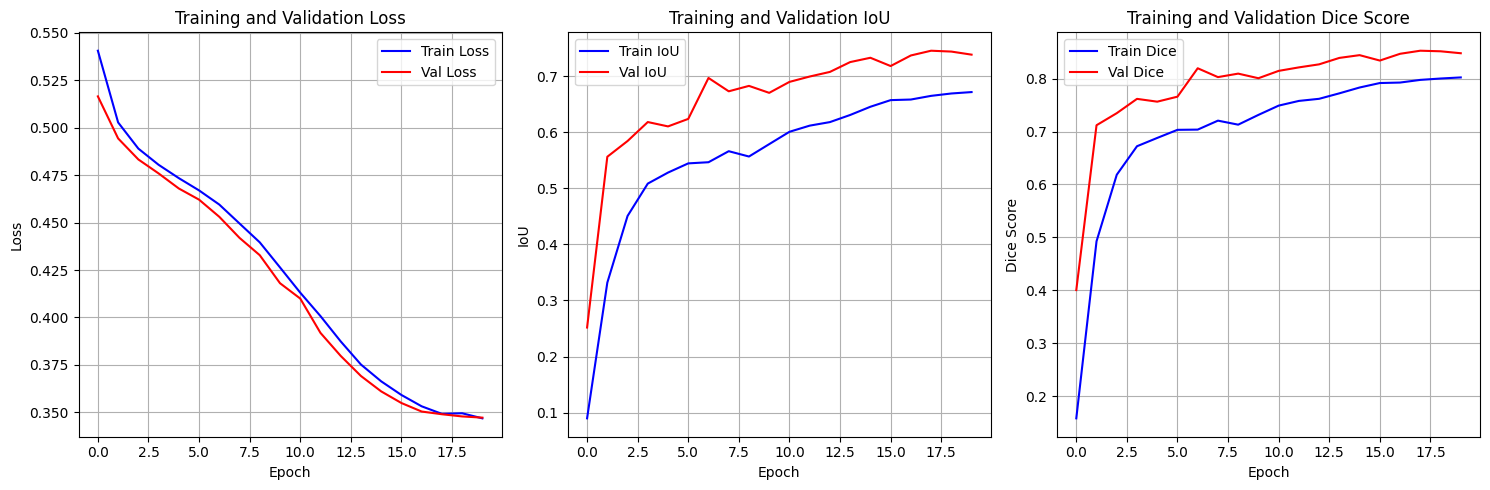

In [ ]:

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_ious, label='Train IoU', color='blue')
plt.plot(val_ious, label='Val IoU', color='red')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_dices, label='Train Dice', color='blue')
plt.plot(val_dices, label='Val Dice', color='red')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **5. Inference**

In [ ]:

def infer_new_image(model, image_path, output_path, transform):
    """Inference function for new images"""
    model.eval()

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Tidak dapat membaca gambar: {image_path}")

    original = image.copy()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply transform
    transformed = transform(image=image_rgb)
    image_tensor = transformed['image'].unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        mask_pred = torch.sigmoid(output).squeeze().cpu().numpy()

    # Threshold mask
    mask_binary = (mask_pred > 0.5).astype(np.uint8) * 255

    # Resize mask to original size
    mask_resized = cv2.resize(mask_binary, (original.shape[1], original.shape[0]),
                             interpolation=cv2.INTER_NEAREST)

    # Apply mask to original image
    segmented = cv2.bitwise_and(original, original, mask=mask_resized)

    # Create overlay
    overlay = original.copy()
    overlay[mask_resized > 0] = [0, 255, 0]  # Green overlay
    blended = cv2.addWeighted(original, 0.7, overlay, 0.3, 0)

    # Save results
    cv2.imwrite(output_path, segmented)
    cv2.imwrite(output_path.replace('.png', '_overlay.png'), blended)

    # Visualize results
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image", fontsize=14)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(mask_pred, cmap='gray')
    plt.title("Predicted Probability Map", fontsize=14)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.title("Overlay Result", fontsize=14)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    plt.title("Segmented Result", fontsize=14)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Hasil segmentasi disimpan di: {output_path}")
    print(f"Overlay disimpan di: {output_path.replace('.png', '_overlay.png')}")

    return mask_pred, mask_resized



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load best model for inference
checkpoint = torch.load("best_unet_resnet50_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
print(f"Model terbaik dimuat dengan IoU: {checkpoint['best_iou']:.4f}")


Model terbaik dimuat dengan IoU: 0.7453



INFERENCE EXAMPLE


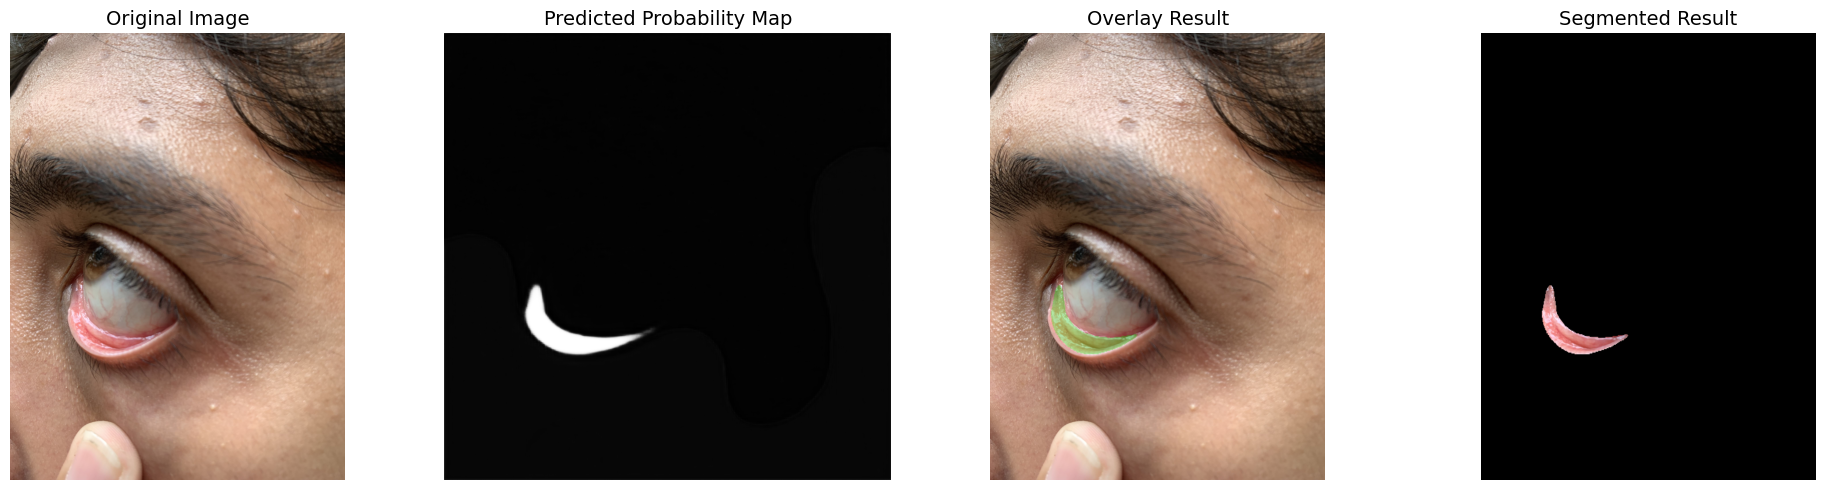

Hasil segmentasi disimpan di: unet_resnet_output.png
Overlay disimpan di: unet_resnet_output_overlay.png

Performing batch inference on 3 images...


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

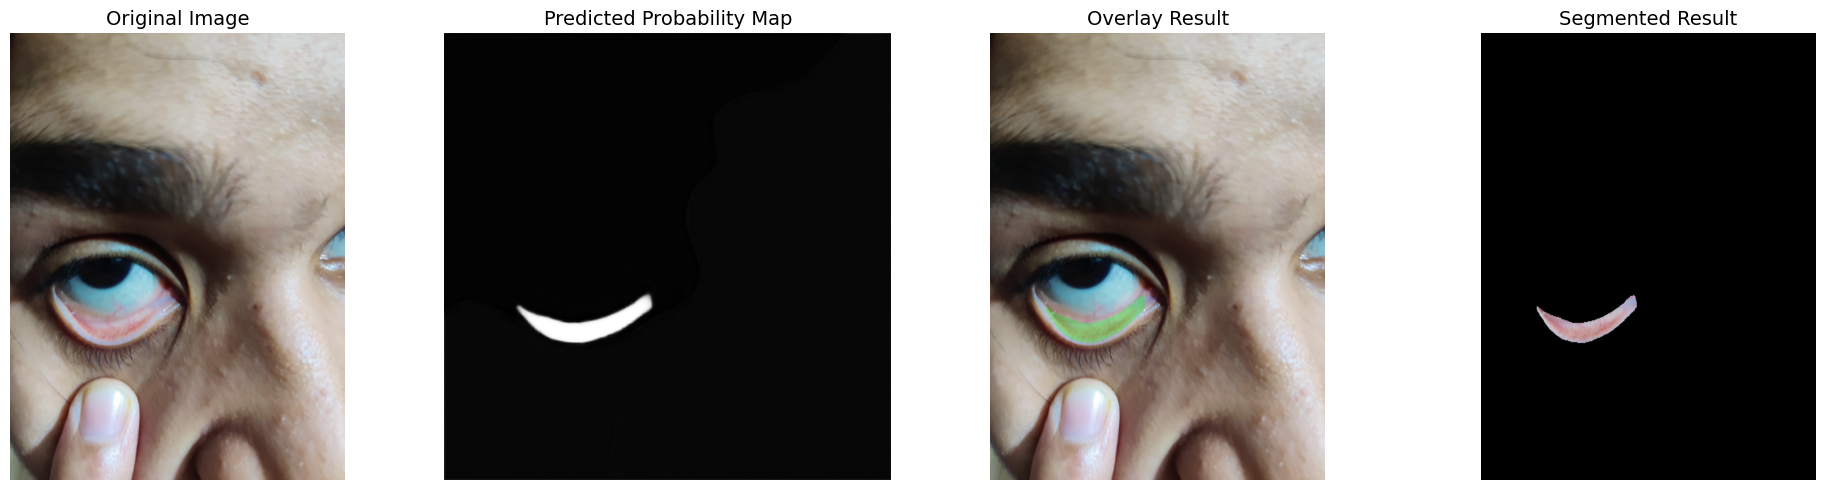

Processing:  33%|███▎      | 1/3 [00:05<00:10,  5.32s/it]

Hasil segmentasi disimpan di: batch_results/segmented_267.png
Overlay disimpan di: batch_results/segmented_267_overlay.png


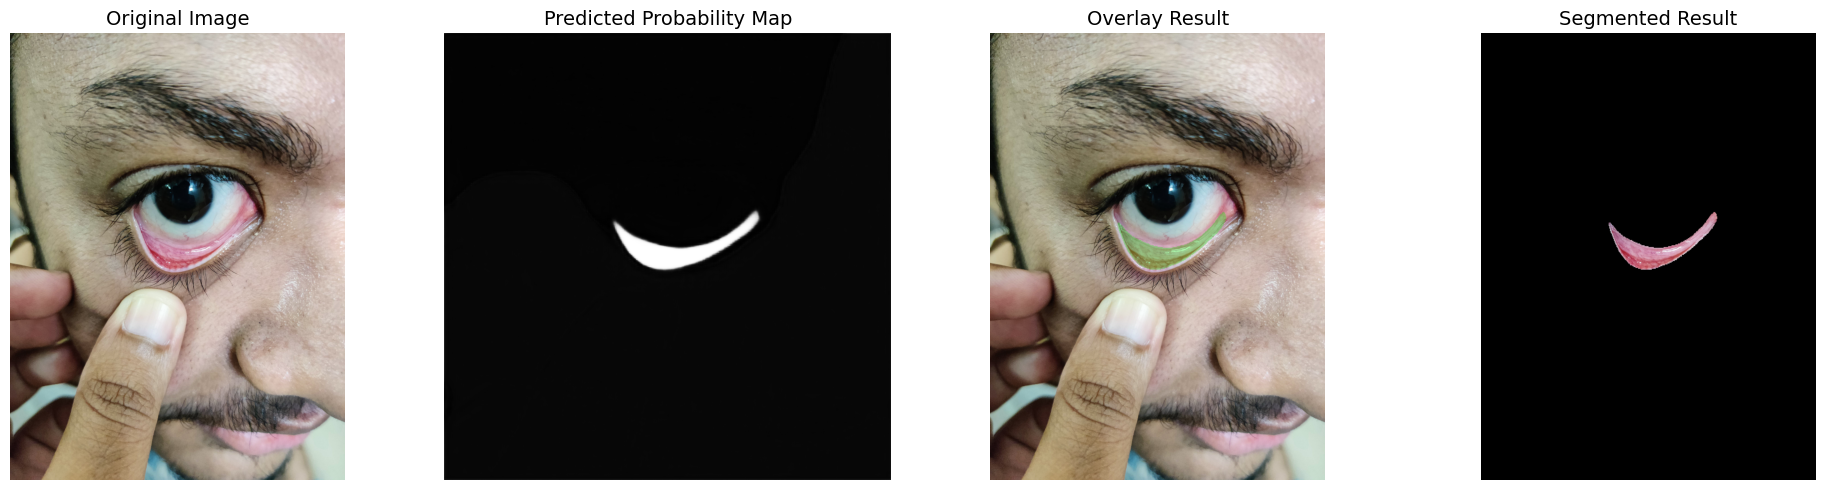

Processing:  67%|██████▋   | 2/3 [00:10<00:05,  5.29s/it]

Hasil segmentasi disimpan di: batch_results/segmented_165.png
Overlay disimpan di: batch_results/segmented_165_overlay.png


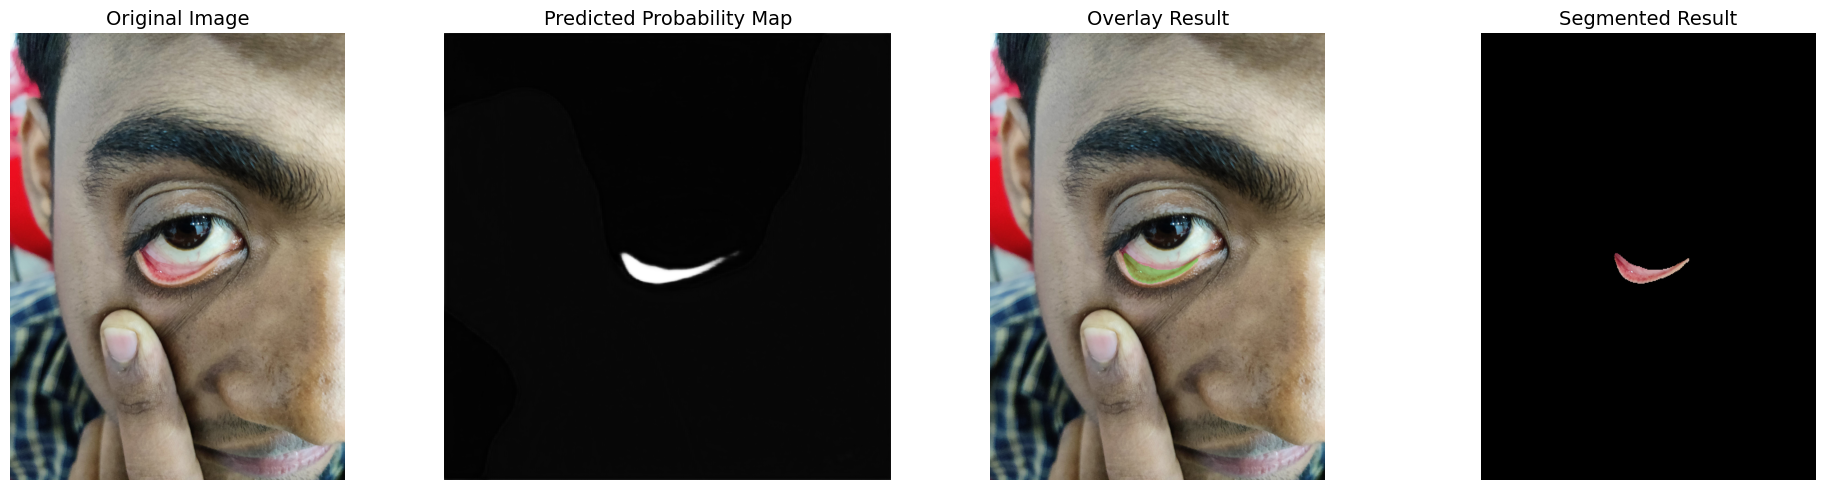

Processing: 100%|██████████| 3/3 [00:16<00:00,  5.38s/it]

Hasil segmentasi disimpan di: batch_results/segmented_395.png
Overlay disimpan di: batch_results/segmented_395_overlay.png
Batch inference selesai. Hasil disimpan di: batch_results


In [ ]:
# Example inference
print("\n" + "="*60)
print("INFERENCE EXAMPLE")
print("="*60)

mask_pred, mask_binary = infer_new_image(
    model,
    "/kaggle/working/extracted_dataset/Eye Conjunctiva Segmentation Dataset/Images/1.png",
    "unet_resnet_output.png",
    valid_transform
)

# Batch inference function
def batch_inference(model, image_folder, output_folder, transform, max_images=5):
    """Perform batch inference on multiple images"""
    os.makedirs(output_folder, exist_ok=True)

    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files = image_files[:max_images]  # Limit number of images

    print(f"\nPerforming batch inference on {len(image_files)} images...")

    for i, image_file in enumerate(tqdm(image_files, desc="Processing")):
        image_path = os.path.join(image_folder, image_file)
        output_path = os.path.join(output_folder, f"segmented_{image_file}")

        try:
            _, _ = infer_new_image(model, image_path, output_path, transform)
        except Exception as e:
            print(f"Error processing {image_file}: {e}")

    print(f"Batch inference selesai. Hasil disimpan di: {output_folder}")

# Perform batch inference on sample images
batch_inference(
    model,
    IMAGE_DIR,
    "batch_results",
    valid_transform,
    max_images=3
)

# **6. Menyimpan Model**

In [ ]:
# 1. Buat ulang instance model
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,      # harus None saat load dari checkpoint
    in_channels=3,
    classes=1,
    activation=None,
)

# 2. Load state_dict
checkpoint = torch.load("/kaggle/working/best_unet_resnet50_model.pth", map_location='cuda')

if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)  # kalau langsung state_dict

model.eval()

# 3. TorchScript export
example_input = torch.randn(1, 3, 512, 512)  # Ubah jika ukuran input berbeda
traced_model = torch.jit.trace(model, example_input)
traced_model.save("model512_unet_resnet50_traced.pt")


# **7. Conclusion**

### 1. **Performa Pelatihan dan Validasi**
Dari hasil pelatihan selama 20 epoch, model UNet dengan backbone ResNet50 menunjukkan performa yang cukup baik dalam tugas segmentasi konjungtiva palpebral. Berikut adalah beberapa poin penting:

- **Loss**:
  - Kurva loss untuk pelatihan (train) dan validasi (val) menunjukkan tren penurunan yang konsisten seiring dengan bertambahnya epoch. Loss terendah pada set pelatihan mencapai sekitar **0.3469** di epoch ke-20, sementara loss terendah pada set validasi mencapai **0.3472** di epoch yang sama.
  - Meskipun ada sedikit fluktuasi, kurva loss menunjukkan bahwa model berhasil belajar dari data pelatihan tanpa overfitting signifikan, karena gap antara train loss dan val loss tetap relatif kecil.

- **IoU (Intersection over Union)**:
  - IoU adalah metrik yang mengukur seberapa baik prediksi masker overlap dengan ground truth.
  - Pada set pelatihan, IoU meningkat secara konsisten hingga mencapai **0.6715** di epoch ke-20.
  - Pada set validasi, IoU tertinggi dicapai pada epoch ke-18 dengan nilai **0.7453**, kemudian sedikit menurun menjadi **0.7382** di epoch ke-20. Ini menunjukkan bahwa model memiliki generalisasi yang baik terhadap data yang tidak pernah dilihat sebelumnya.

- **Dice Score**:
  - Dice score adalah metrik lain yang mengukur kesamaan antara prediksi dan ground truth, mirip dengan IoU tetapi lebih toleran terhadap ukuran area.
  - Pada set pelatihan, Dice score meningkat hingga mencapai **0.8023** di epoch ke-20.
  - Pada set validasi, Dice score tertinggi dicapai pada epoch ke-18 dengan nilai **0.8528**, kemudian menurun sedikit menjadi **0.8481** di epoch ke-20. Performa ini menunjukkan bahwa model mampu memprediksi masker dengan akurasi tinggi.

### 2. **Peningkatan Metrik Secara Keseluruhan**
- Dari grafik **Training and Validation Loss**, **Training and Validation IoU**, dan **Training and Validation Dice Score**, dapat dilihat bahwa semua metrik utama (loss, IoU, dan Dice score) mengalami peningkatan yang signifikan sepanjang proses pelatihan.
- Model berhasil mengoptimalkan kombinasi loss function (CombinedLoss, yang menggabungkan DiceLoss dan FocalLoss), sehingga mampu menangani ketidakseimbangan kelas dan meningkatkan performa keseluruhan.

### 3. **Overfitting dan Generalisasi**
- Tidak ada indikasi kuat bahwa model mengalami overfitting, karena:
  - Gap antara train loss dan val loss tetap kecil.
  - IoU dan Dice score pada set validasi terus meningkat hingga epoch ke-18, meskipun ada sedikit penurunan di beberapa epoch berikutnya.
  - Penjadwal learning rate (CosineAnnealingLR) membantu menghindari overfitting dengan cara mengurangi learning rate secara bertahap seiring dengan bertambahnya epoch.

### 4. **Model Terbaik**
- Model terbaik disimpan berdasarkan nilai IoU tertinggi pada set validasi, yaitu **0.7453** di epoch ke-18.
- Model ini memiliki performa yang stabil dan konsisten, dengan Dice score sebesar **0.8528** pada epoch yang sama.

### 5. **Augmentasi Data dan Transformasi**
- Penggunaan augmentasi data (seperti flip horizontal, rotasi, brightness/contrast adjustment, dll.) sangat membantu dalam meningkatkan variasi data pelatihan, sehingga model lebih robust terhadap variasi input.
- Transformasi seperti normalisasi juga penting untuk memastikan distribusi fitur gambar sesuai dengan standar pre-trained weights dari ResNet50.

### 6. **Inference dan Hasil Visual**
- Proses inferensi pada gambar baru menunjukkan hasil segmentasi yang akurat, dengan overlay masker yang sesuai dengan objek target (konjungtiva palpebral).
- Gambar hasil segmentasi dan overlay menunjukkan bahwa model mampu membedakan area konjungtiva dengan baik, meskipun ada beberapa noise atau area yang belum sempurna.

### 7. **Rekomendasi untuk Perbaikan**
- **Epoch Tambahan**: Meskipun performa sudah cukup baik, model masih bisa dilatih lebih lama untuk mencapai performa maksimal. Misalnya, melanjutkan pelatihan hingga epoch ke-30 atau lebih.
- **Hyperparameter Tuning**: Optimasi lebih lanjut terhadap hyperparameter seperti learning rate, alpha/beta dalam CombinedLoss, atau jumlah layer dalam encoder/decoder dapat meningkatkan performa.
- **Data Augmentasi Lebih Lanjut**: Menambah jenis transformasi augmentasi lainnya, seperti crop, shear, atau color jitter, dapat membantu model lebih adaptif terhadap variasi data.
- **Penambahan Data**: Jika tersedia, menambah jumlah data pelatihan dapat meningkatkan generalisasi model.

## Kesimpulan Akhir
Model UNet dengan backbone ResNet50 berhasil melakukan segmentasi konjungtiva palpebral dengan baik, dengan metrik evaluasi (IoU dan Dice score) yang cukup tinggi. Performa model stabil dan tidak menunjukkan overfitting signifikan. Namun, masih ada potensi untuk peningkatan lebih lanjut melalui pelatihan lebih lama, optimasi hyperparameter, atau penambahan data. Overall, model ini siap digunakan untuk aplikasi praktis dalam segmentasi konjungtiva palpebral.